# Image recognition with Python, OpenCV

## Step 1: Install requirements

In [1]:
!pip install opencv-python imgbeddings psycopg2-binary

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00
  Created wheel for imgbeddings: filename=imgbeddings-0.1.0-py3-none-any.whl size=9324 sha256=fe9c0906437ea20b27a93dc23cab4e8df00c6f41de29f647afbf25986e4873f2
  Stored in directory: /root/.cache/pip/wheels/44/25/45/faf940ae980b321ddb51becf6a38c32800af42853801c17cd0
Successfully built imgbeddings


In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 2: Face recognition

Detect the faces from the test-images

In [12]:
# importing the cv2 library, os and the others needed
import cv2
import os
import numpy as np

# loading the haar case algorithm file into alg variable
alg = "/content/drive/MyDrive/Colab Notebooks/Face_recognition/haarcascade_frontalface_default.xml"

# passing the algorithm to OpenCV
haar_cascade = cv2.CascadeClassifier(alg)

# creating the extract_face function
def extract_face(filename, required_size=(160, 160)):

    #Extracts face from an image using HAAR cascade
    img = cv2.imread(filename)
    if img is None:
        return None
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to gray scale image
    faces = haar_cascade.detectMultiScale(gray_img, 1.1, 4) # 1.1 is the scale-factor while 4 is MinNeighbor

    if len(faces) == 0:
        return None  # No face found

    x, y, w, h = faces[0]  # Take the first detected face
    face = img[y:y+h, x:x+w]  # Crop the face
    face = cv2.resize(face, required_size)  # Resize to (160,160)
    return face

In [9]:
def load_faces(directory):

    # Loads all the faces from the directory
    faces = []
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        face = extract_face(path)
        if face is not None:
            faces.append(face)
    return faces

In [10]:
def load_dataset(parent_directory):

    # Loading the dataset and assigning labels based on folder names
    X, y = [], []

    for subdir in os.listdir(parent_directory):
        path = os.path.join(parent_directory, subdir)
        if not os.path.isdir(path):
            continue  # Skip files
        faces = load_faces(path)
        labels = [subdir] * len(faces)  # Assign label to each face
        X.extend(faces)
        y.extend(labels)

    return np.array(X), np.array(y)

In [33]:
X_train, y_train = load_dataset('/content/drive/MyDrive/Colab Notebooks/Face_recognition/dataset/Train')
X_test, y_test = load_dataset('/content/drive/MyDrive/Colab Notebooks/Face_recognition/dataset/Test')

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (769, 160, 160, 3), (769,)
Test set: (189, 160, 160, 3), (189,)


# Step 3: Face Embedding with FaceNet
Calculate embeddings from the faces

In [14]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.4 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=8e76e3082c13d98897a1315f6a0965e58adb14dda5cb55bacfca3e68c33f9906
  Stored in directory: /root/.cache/pip/wheels/99/94/dd/cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet


In [15]:
from keras_facenet import FaceNet
import numpy as np

In [17]:
# Load the FaceNet model
facenet_model = FaceNet()

# creating the get_embedding function
def get_embedding(model, face_image):
    """Generates an embedding for a given face using a pre-trained model."""
    face_image = np.expand_dims(face_image, axis=0)  # Add batch dimension
    embedding = model.embeddings(face_image)  # Get the face embedding
    return embedding[0]  # Return the 128-dimensional feature vector

In [34]:
# Generating embeddings for training images
X_train = np.array([get_embedding(facenet_model, face) for face in X_train])
X_test = np.array([get_embedding(facenet_model, face) for face in X_test])

# Converting the labels (strings) into NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [35]:
# Save train and test embeddings to a file
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/Face_recognition/face_embeddings.npz', X_train, y_train, X_test, y_test)

# Step 4: Training Face Recognition Model

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [36]:
print(X_train.shape)  # Should be (num_samples, 128) or (num_samples, feature_dim)
print(X_test.shape)   # Should be (num_samples, 128) or (num_samples, feature_dim)


(769, 512)
(189, 512)


In [43]:
# Train the SVM classifier
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Predict on the test set
test_preds = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, test_preds)
print(f"SVM Test Accuracy: {accuracy:.4f}")


SVM Test Accuracy: 0.9259


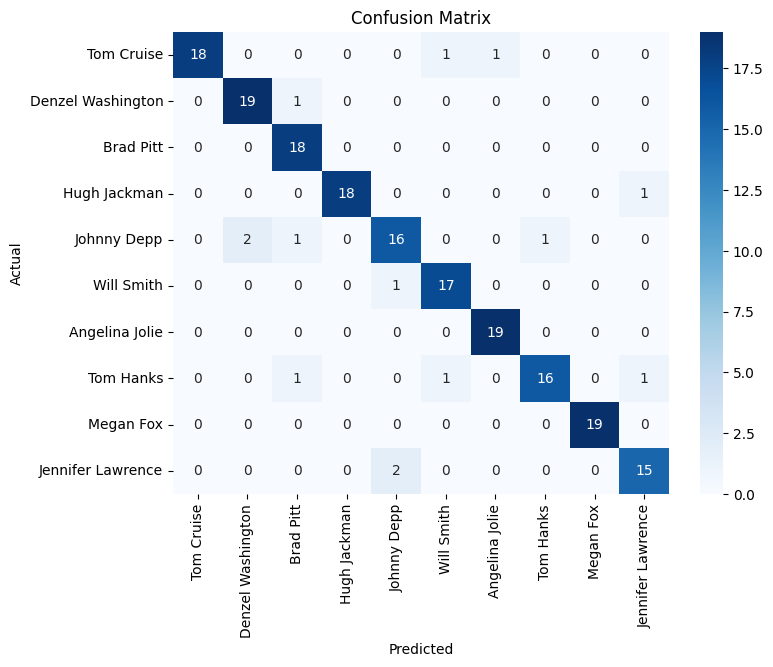

                   precision    recall  f1-score   support

   Angelina Jolie       1.00      0.90      0.95        20
        Brad Pitt       0.90      0.95      0.93        20
Denzel Washington       0.86      1.00      0.92        18
     Hugh Jackman       1.00      0.95      0.97        19
Jennifer Lawrence       0.84      0.80      0.82        20
      Johnny Depp       0.89      0.94      0.92        18
        Megan Fox       0.95      1.00      0.97        19
       Tom Cruise       0.94      0.84      0.89        19
        Tom Hanks       1.00      1.00      1.00        19
       Will Smith       0.88      0.88      0.88        17

         accuracy                           0.93       189
        macro avg       0.93      0.93      0.93       189
     weighted avg       0.93      0.93      0.93       189



In [38]:
# Generate confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Visualize it
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# detailed classification report
print(classification_report(y_test, test_preds))

# Experimenting with Other Classifiers

In [41]:
# KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
print("KNN Accuracy:", accuracy_score(y_test, knn_model.predict(X_test)))

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_model.predict(X_test)))

KNN Accuracy: 0.9259259259259259
Random Forest Accuracy: 0.9259259259259259


# Saving the model

In [46]:
import pickle

# Save the model
pickle.dump(svm_model, open("/content/drive/MyDrive/Colab Notebooks/Face_recognition/svm_face_model.pkl", 'wb'))